In [1]:
# ==============================================================================
# PHASE 2: LATENT DIFFUSION MODEL (GENERATION)
# ==============================================================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# --- 1. CONFIGURATION ---
CONF = {
    # UPDATE PATH to where you uploaded the 3 files
    "LATENTS_PATH": "/kaggle/input/datasets/haytamrais/human-protein-latents/latents_train.npz",
    "DECODER_PATH": "/kaggle/input/datasets/haytamrais/human-protein-latents/decoder_final.pth",
    "BATCH_SIZE": 64,
    "EPOCHS": 100,        # Diffusion needs more epochs, but they are fast!
    "LR": 3e-4,
    "TIMESTEPS": 1000,    # Standard diffusion steps
    "LATENT_DIM": 16,     # 16 channels from Phase 1
    "IMG_SIZE": 16,       # 16x16 spatial dim from Phase 1
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"🚀 Phase 2: Diffusion on {CONF['DEVICE']}")

🚀 Phase 2: Diffusion on cuda


In [3]:
# --- 2. DATASET (Latents are tiny, load to RAM) ---
class LatentDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.latents = torch.from_numpy(data['latents']).float()
        # Normalization: Latents are usually around -3 to 3. 
        # We standard scaling helps diffusion.
        self.mean = self.latents.mean()
        self.std = self.latents.std()
        self.latents = (self.latents - self.mean) / self.std
        print(f"✅ Loaded {len(self.latents)} latents. Mean={self.mean:.2f}, Std={self.std:.2f}")

    def __len__(self): return len(self.latents)
    def __getitem__(self, idx): return self.latents[idx]

In [7]:
# --- 3. THE DIFFUSION U-NET ---
# A simple but powerful U-Net for 16x16 inputs
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
        self.bn = nn.GroupNorm(8, out_c)
        self.act = nn.SiLU()
    def forward(self, x): return self.act(self.bn(self.conv1(x)))

class DiffusionUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(64),
            nn.Linear(64, 128), nn.SiLU(),
            nn.Linear(128, 64)  # <--- FIXED: Changed from 128 to 64 to match x1
        )
        
        # Encoder
        self.inc = Block(16, 64)           # 16x16 -> 64 channels
        self.down1 = Block(64, 128)        # 64 -> 128 channels
        self.down_pool = nn.MaxPool2d(2)
        self.down2 = Block(128, 256)       # 128 -> 256 channels
        
        # Bottleneck
        self.bot = Block(256, 256)
        
        # Decoder
        self.up1 = nn.Upsample(scale_factor=2)
        self.up_conv1 = Block(256 + 128, 128)
        self.up2 = nn.Upsample(scale_factor=2)
        self.up_conv2 = Block(128 + 64, 64)
        self.outc = nn.Conv2d(64, 16, 1)

    def forward(self, x, t):
        # t is now [Batch, 64, 1, 1]
        t = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1) 
        
        # Down
        x1 = self.inc(x)
        # Now 64 + 64 works perfectly
        x2 = self.down1(self.down_pool(x1) + t) 
        x3 = self.down2(self.down_pool(x2))
        
        # Bot
        x3 = self.bot(x3)
        
        # Up
        x = self.up1(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.up_conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv2(x)
        
        return self.outc(x)

In [8]:
# --- 4. DIFFUSION UTILS ---
class DiffusionManager:
    def __init__(self):
        self.beta = torch.linspace(1e-4, 0.02, CONF['TIMESTEPS']).to(CONF['DEVICE'])
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=CONF['TIMESTEPS'], size=(n,), device=CONF['DEVICE'])

In [9]:
# --- 5. TRAINING ---
if __name__ == "__main__":
    # Load Data
    ds = LatentDataset(CONF['LATENTS_PATH'])
    loader = DataLoader(ds, batch_size=CONF['BATCH_SIZE'], shuffle=True)
    
    # Init Model
    model = DiffusionUNet().to(CONF['DEVICE'])
    optimizer = optim.AdamW(model.parameters(), lr=CONF['LR'])
    mse = nn.MSELoss()
    diffusion = DiffusionManager()
    
    print("🔥 Starting Diffusion Training...")
    
    for epoch in range(CONF['EPOCHS']):
        model.train()
        pbar_loss = 0
        for i, images in enumerate(loader):
            images = images.to(CONF['DEVICE'])
            t = diffusion.sample_timesteps(images.shape[0])
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar_loss += loss.item()
            
        print(f"Epoch {epoch+1} | Loss: {pbar_loss/len(loader):.4f}")
        
    # Save the Diffusion Model
    torch.save(model.state_dict(), "diffusion_model.pth")
    print("✅ Diffusion Model Trained & Saved!")

✅ Loaded 34528 latents. Mean=0.02, Std=0.84
🔥 Starting Diffusion Training...
Epoch 1 | Loss: 0.3683
Epoch 2 | Loss: 0.2451
Epoch 3 | Loss: 0.2246
Epoch 4 | Loss: 0.2161
Epoch 5 | Loss: 0.2133
Epoch 6 | Loss: 0.2106
Epoch 7 | Loss: 0.2062
Epoch 8 | Loss: 0.2023
Epoch 9 | Loss: 0.1997
Epoch 10 | Loss: 0.1963
Epoch 11 | Loss: 0.1973
Epoch 12 | Loss: 0.1956
Epoch 13 | Loss: 0.1946
Epoch 14 | Loss: 0.1926
Epoch 15 | Loss: 0.1924
Epoch 16 | Loss: 0.1915
Epoch 17 | Loss: 0.1933
Epoch 18 | Loss: 0.1872
Epoch 19 | Loss: 0.1882
Epoch 20 | Loss: 0.1877
Epoch 21 | Loss: 0.1896
Epoch 22 | Loss: 0.1866
Epoch 23 | Loss: 0.1860
Epoch 24 | Loss: 0.1866
Epoch 25 | Loss: 0.1848
Epoch 26 | Loss: 0.1855
Epoch 27 | Loss: 0.1859
Epoch 28 | Loss: 0.1823
Epoch 29 | Loss: 0.1833
Epoch 30 | Loss: 0.1801
Epoch 31 | Loss: 0.1826
Epoch 32 | Loss: 0.1821
Epoch 33 | Loss: 0.1836
Epoch 34 | Loss: 0.1815
Epoch 35 | Loss: 0.1808
Epoch 36 | Loss: 0.1821
Epoch 37 | Loss: 0.1799
Epoch 38 | Loss: 0.1799
Epoch 39 | Loss: 0.1

⏳ Loading models for sharp inference...
🧬 Generating 8 sharp scaffolds via DDIM (100 steps)...


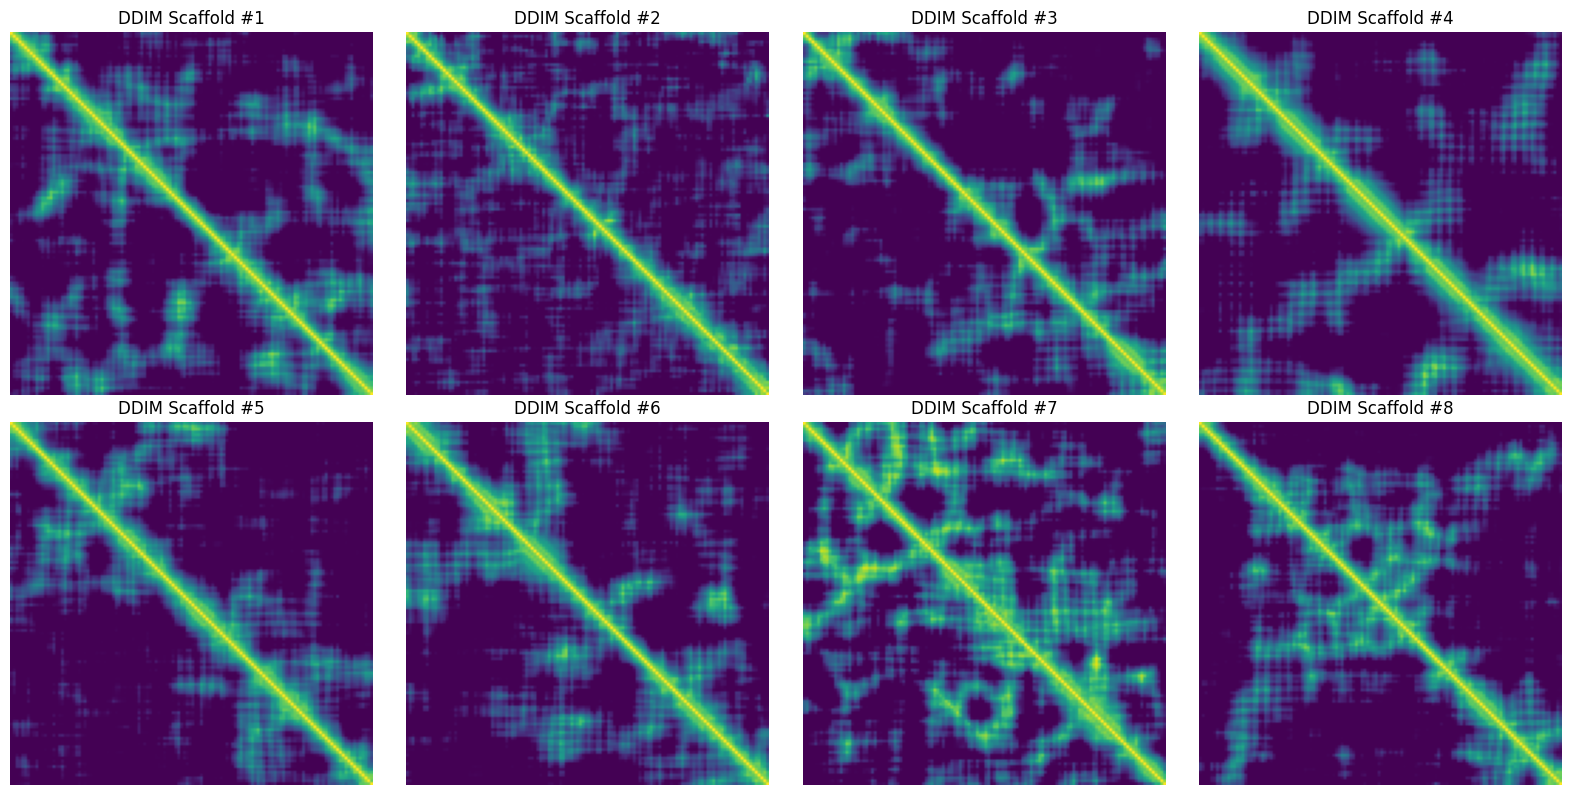

In [15]:
# ==============================================================================
# PHASE 3: SHARP GENERATION (DDIM SAMPLER)
# ==============================================================================

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def ddim_sample(num_samples=8, ddim_steps=50, eta=0.0):
    device = CONF['DEVICE']
    
    # 1. Load Models
    print("⏳ Loading models for sharp inference...")
    diffusion = DiffusionUNet().to(device)
    diffusion.load_state_dict(torch.load("diffusion_model.pth", map_location=device))
    diffusion.eval()
    
    decoder = VAE_Decoder().to(device)
    decoder.load_state_dict(torch.load(CONF['DECODER_PATH'], map_location=device))
    decoder.eval()
    
    # 2. DDIM Schedule
    timesteps = CONF['TIMESTEPS']
    beta = torch.linspace(1e-4, 0.02, timesteps).to(device)
    alpha = 1. - beta
    alpha_hat = torch.cumprod(alpha, dim=0)
    
    # Define the subsequence of steps to take (skipping steps for speed/sharpness)
    times = torch.linspace(0, timesteps - 1, ddim_steps).long().to(device)
    times_next = torch.cat([-torch.ones(1).to(device).long(), times[:-1]])
    
    # 3. The DDIM Loop
    print(f"🧬 Generating {num_samples} sharp scaffolds via DDIM ({ddim_steps} steps)...")
    x = torch.randn((num_samples, 16, 16, 16)).to(device)
    
    with torch.no_grad():
        for i in reversed(range(ddim_steps)):
            # ADDED .to(device) inside these two lines:
            t = (torch.ones(num_samples, device=device) * times[i]).long()
            t_next = (torch.ones(num_samples, device=device) * times_next[i]).long()
            
            # Predict noise
            predicted_noise = diffusion(x, t)
            
            # Get alpha values
            at = alpha_hat[t][:, None, None, None]
            at_next = alpha_hat[t_next][:, None, None, None] if times_next[i] >= 0 else torch.ones_like(at)
            
            # DDIM Formula
            x0_t = (x - torch.sqrt(1 - at) * predicted_noise) / torch.sqrt(at)
            dir_xt = torch.sqrt(1 - at_next - eta**2) * predicted_noise
            
            x = torch.sqrt(at_next) * x0_t + dir_xt
            if eta > 0:
                x += eta * torch.randn_like(x)
    # 4. Decode and Plot
    lat_mean, lat_std = 0.02, 0.84 
    x = (x * lat_std) + lat_mean
    generated_images = decoder(x)
    
    plt.figure(figsize=(16, 8))
    for k in range(num_samples):
        plt.subplot(2, 4, k+1)
        img = generated_images[k, 0].detach().cpu().numpy()
        plt.imshow(img, cmap='viridis')
        plt.title(f"DDIM Scaffold #{k+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run the sharp sampler
ddim_sample(num_samples=8, ddim_steps=100)

⏳ Loading models for Haytam Rais's final report...
🧬 Denoising and decoding structures...


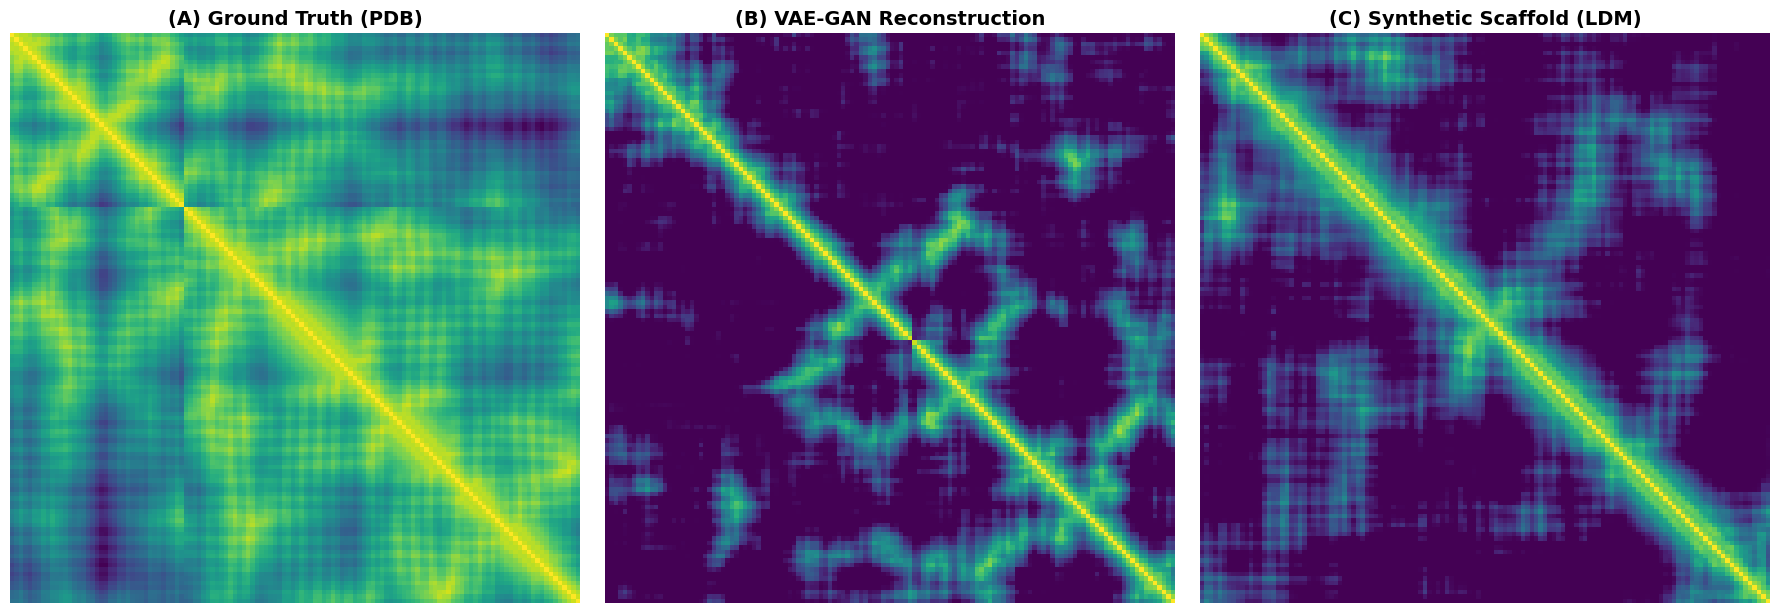

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# --- 1. RE-INSTANTIATE ARCHITECTURES (To load saved weights) ---
# Ensure SelfAttention, ResBlock, VAE_Encoder, and VAE_Decoder classes are defined in this notebook!

def get_comparison_figure():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # A. Load Models
    print("⏳ Loading models for Haytam Rais's final report...")
    # Update these paths to match your current Kaggle environment
    DEC_PATH = "/kaggle/input/datasets/haytamrais/human-protein-latents/decoder_final.pth" 
    DIFF_PATH = "diffusion_model.pth" 
    
    decoder = VAE_Decoder().to(device)
    decoder.load_state_dict(torch.load(DEC_PATH, map_location=device))
    decoder.eval()
    
    diffusion = DiffusionUNet().to(device)
    diffusion.load_state_dict(torch.load(DIFF_PATH, map_location=device))
    diffusion.eval()

    # B. Setup DDIM Schedule
    timesteps = 1000
    beta = torch.linspace(1e-4, 0.02, timesteps).to(device)
    alpha = 1. - beta
    alpha_hat = torch.cumprod(alpha, dim=0)
    ddim_steps = 100
    times = torch.linspace(0, timesteps - 1, ddim_steps).long().to(device)
    times_next = torch.cat([-torch.ones(1).to(device).long(), times[:-1]])

    # C. Data Loading (Ground Truth & Validation Latents)
    # Using 'contact_maps' key as identified previously
    real_data = np.load("/kaggle/input/datasets/haytamrais/human-protein-distograms-43k/protein_dataset_human_128x128.npz")
    idx = int(len(real_data['contact_maps']) * 0.9) 
    real_img = torch.from_numpy(real_data['contact_maps'][idx:idx+1]).float().unsqueeze(1).to(device)
    
    val_latents = np.load("/kaggle/input/datasets/haytamrais/human-protein-latents/latents_val.npz")['latents']
    latent_sample = torch.from_numpy(val_latents[0:1]).float().to(device)

    # D. Generation and Reconstruction
    print(f"🧬 Denoising and decoding structures...")
    x_gen = torch.randn((1, 16, 16, 16), device=device)
    
    with torch.no_grad():
        # Phase 1: VAE Reconstruction
        # We un-normalize the latent before decoding
        vae_recon = decoder((latent_sample * 0.84) + 0.02)
        
        # Phase 2: DDIM Generation Loop
        for i in reversed(range(ddim_steps)):
            t = (torch.ones(1, device=device) * times[i]).long()
            t_next = (torch.ones(1, device=device) * times_next[i]).long()
            
            pred_noise = diffusion(x_gen, t)
            at = alpha_hat[t][:, None, None, None]
            at_next = alpha_hat[t_next][:, None, None, None] if times_next[i] >= 0 else torch.ones_like(at)
            
            x0_t = (x_gen - torch.sqrt(1 - at) * pred_noise) / torch.sqrt(at)
            dir_xt = torch.sqrt(1 - at_next) * pred_noise
            x_gen = torch.sqrt(at_next) * x0_t + dir_xt
            
        # Final Generation Decoded
        generated_img = decoder((x_gen * 0.84) + 0.02)

    # # E. Robust Visualization
    # plt.figure(figsize=(18, 6))
    
    # # We use a dictionary to avoid list indexing errors
    # plot_data = [
    #     {"data": real_img, "title": "(A) Ground Truth (PDB)"},
    #     {"data": vae_recon, "title": "(B) VAE-GAN Reconstruction"},
    #     {"data": generated_img, "title": "(C) Synthetic Scaffold (LDM)"}
    # ]
    
    # for i, item in enumerate(plot_data):
    #     plt.subplot(1, 3, i+1)
    #     # SQUEEZE ensures we get a 2D (128, 128) array for imshow
    #     img_np = item["data"].detach().cpu().squeeze().numpy()
        
    #     plt.imshow(img_np, cmap='viridis')
    #     plt.title(item["title"], fontweight='bold', fontsize=14)
    #     plt.axis('off')
    
    # plt.tight_layout()
    # plt.savefig("structural_comparison_final.png", dpi=300)
    # plt.show()
    # print("✅ Figure saved as structural_comparison_final.png")

    # E. Robust Visualization
    plt.figure(figsize=(18, 6))
    
    # --- THE FIX: Convert Ground Truth from Distance to Proximity ---
    # We invert the ground truth: New = 1 - (Old / Max)
    # This makes small distances (dark) become high intensity (bright yellow)
    real_img_viz = 1.0 - (real_img / torch.max(real_img))
    
    plot_data = [
        {"data": real_img_viz, "title": "(A) Ground Truth (PDB)"},
        {"data": vae_recon,    "title": "(B) VAE-GAN Reconstruction"},
        {"data": generated_img, "title": "(C) Synthetic Scaffold (LDM)"}
    ]
    
    for i, item in enumerate(plot_data):
        plt.subplot(1, 3, i+1)
        img_np = item["data"].detach().cpu().squeeze().numpy()
        
        plt.imshow(img_np, cmap='viridis')
        plt.title(item["title"], fontweight='bold', fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig("structural_comparison_final.png", dpi=300)
    plt.show()

get_comparison_figure()

In [19]:
import numpy as np
real_data = np.load("/kaggle/input/datasets/haytamrais/human-protein-distograms-43k/protein_dataset_human_128x128.npz")
print(f"✅ The keys in your file are: {real_data.files}")

✅ The keys in your file are: ['contact_maps', 'masks', 'pdb_ids']
